# 6.1 매개변수 갱신
## 6.1.2 확률적 경사 하강법(SGD)

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

## 6.1.4 모멘텀

In [3]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

## 6.1.5 AdaGrad

In [5]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.item():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

## 6.1.7 어느 갱신 방법을 이용할 것인가?
### SGD, 모멘텀, AdaGrad, Adam의 학습 패턴을 비교합니다.

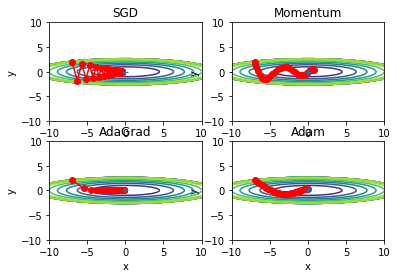

In [6]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

## 6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교
### SGD, 모멘텀, AdaGrad, Adam의 학습 속도를 비교합니다.

===========iteration:0===========
SGD:2.297228360664712
Momentum:2.399064929544986
AdaGrad:2.0189004568316253
Adam:2.1985613855138926
===========iteration:100===========
SGD:1.3631961864994269
Momentum:0.4433375947340523
AdaGrad:0.21370843329284508
Adam:0.3545796878901095
===========iteration:200===========
SGD:0.7871972322314487
Momentum:0.3232100029354068
AdaGrad:0.11884743484316883
Adam:0.27728999712736435
===========iteration:300===========
SGD:0.6841044391065179
Momentum:0.27661840744979227
AdaGrad:0.11197801680609416
Adam:0.13989752193254176
===========iteration:400===========
SGD:0.5719523948996168
Momentum:0.16480514127513318
AdaGrad:0.06395307972586178
Adam:0.10955096918931395
===========iteration:500===========
SGD:0.3697327431504405
Momentum:0.17056263041346148
AdaGrad:0.10617009436340066
Adam:0.12063791891362412
===========iteration:600===========
SGD:0.3472768414670633
Momentum:0.1791823139809755
AdaGrad:0.11488955080027967
Adam:0.13261661566425126
===========iteration:700

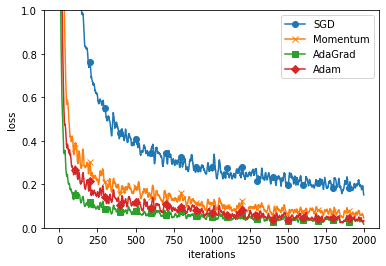

In [7]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

# 6.2 가중치의 초깃값
## 6.2.2 은닉층의 활성화값 분포
### 활성화 함수로 시그모이드 함수를 사용하는 5층 신경망에 무작위로 생성한 입력 데이터를 흘리며 
### 각 층의 활성화값 분포를 히스토그램으로 그려봅니다.

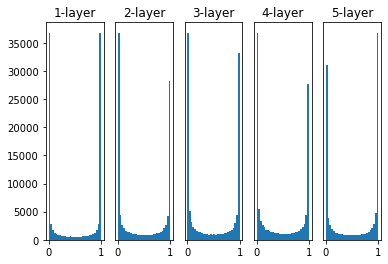

In [6]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

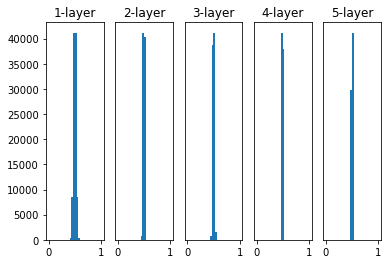

In [7]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    # w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

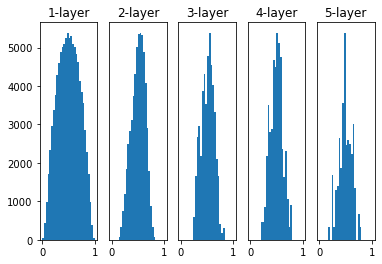

In [9]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

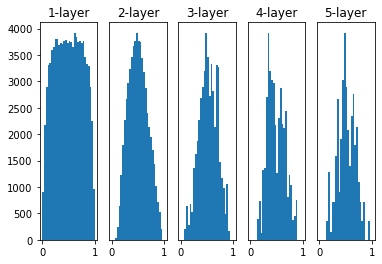

In [10]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

## ⭐Xavier 초기값

- 이 초기값의 목적: 각 층의 활성화값들을 광범위하게 분포 → 가중치의 적절한 분포 찾기 위해

- 방법: n개의 노드가 있다면 표준편차가 $1/n^(0.5)$인 분포 사용

![title](초기값설정.png)

- 위 수식에서 알 수 있듯이 앞 층에 노드가 많을수록 대상 노드의 초기값으로 설정하는 가중치가 좁게 퍼짐

![title](초기값설정1.png)

- 층이 깊어질수록 (형태가 다소 일그러지지만) 확실히 앞에서 본 방법보다 더 넓게 분포!

 

## ❗ReLU사용할 때의 가중치 초기값

- 카이밍 히가 찾아낸 He초기값

- 앞 계층의 노드가 n개일 때, 표준편차가 $(2/n)^(0.5)$사용

![title](초기값설정2.png)


# 결론

- 표준편차 = 0.01인 정규분포, Xavier 초기값, He초기값 사용한 경우
- Xavier 초기값: 층이 깊어지면서 치우침이 커짐 → 기울시 소실 문제 발생
- He 초기값: 모든 층에서 균일하게 분포 → 역전파 때도 적절한 값이 나옴

## 🔥초기값에 대한 결론

- ***ReLU***를 사용할 때는 ***He 초기값*** 사용
- ***시그모이드*** 또는 ***tanh*** 등의 S자 모양 곡선일 때는 ***Xavier 초기값*** 사용

## 6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교
### 가중치 초깃값(std=0.01, He, Xavier)에 따른 학습 속도를 비교합니다.

===========iteration:0===========
std=0.01:2.302538530901186
Xavier:2.2985935926262293
He:2.323113322505254
===========iteration:100===========
std=0.01:2.3024469244753454
Xavier:2.2510441983830654
He:1.6423329780729394
===========iteration:200===========
std=0.01:2.3015731179588244
Xavier:2.140589583629284
He:0.7981890698355087
===========iteration:300===========
std=0.01:2.300441876896696
Xavier:1.861263175471843
He:0.5766919840399414
===========iteration:400===========
std=0.01:2.30301358981412
Xavier:1.4473195473498133
He:0.49192892636896046
===========iteration:500===========
std=0.01:2.3008301818118806
Xavier:1.0167617794867108
He:0.4116225318316068
===========iteration:600===========
std=0.01:2.2995916747206406
Xavier:0.6645245770997785
He:0.30362376185061407
===========iteration:700===========
std=0.01:2.3064884795550418
Xavier:0.6054968901697808
He:0.2848367883948593
===========iteration:800===========
std=0.01:2.2995309723790953
Xavier:0.5529756074360759
He:0.3278455273057943

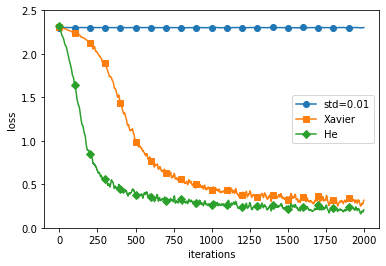

In [1]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)6.1.7 어느 갱신 방법을 이용할 것인가?
plt.legend()
plt.show()

## 6.3.2 배치 정규화의 효과
### MNIST 데이터셋 학습에 배치 정규화를 적용해봅니다.

============== 1/16 ==============
epoch:0 | 0.093 - 0.079
epoch:1 | 0.097 - 0.093
epoch:2 | 0.097 - 0.121


/home/aiffel0042/aiffel/Deep_Learning_from_Scratch/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/home/aiffel0042/aiffel/Deep_Learning_from_Scratch/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/home/aiffel0042/aiffel/Deep_Learning_from_Scratch/common/functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)
/home/aiffel0042/aiffel/Deep_Learning_from_Scratch/common/layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)


epoch:3 | 0.097 - 0.125
epoch:4 | 0.097 - 0.155
epoch:5 | 0.097 - 0.177
epoch:6 | 0.097 - 0.189
epoch:7 | 0.097 - 0.213
epoch:8 | 0.097 - 0.241
epoch:9 | 0.097 - 0.258
epoch:10 | 0.097 - 0.277
epoch:11 | 0.097 - 0.297
epoch:12 | 0.097 - 0.335
epoch:13 | 0.097 - 0.348
epoch:14 | 0.097 - 0.351
epoch:15 | 0.097 - 0.357
epoch:16 | 0.097 - 0.382
epoch:17 | 0.097 - 0.398
epoch:18 | 0.097 - 0.411


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.422
============== 2/16 ==============
epoch:0 | 0.117 - 0.123
epoch:1 | 0.097 - 0.14
epoch:2 | 0.097 - 0.162
epoch:3 | 0.097 - 0.184


/home/aiffel0042/aiffel/Deep_Learning_from_Scratch/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/home/aiffel0042/aiffel/Deep_Learning_from_Scratch/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/aiffel0042/aiffel/Deep_Learning_from_Scratch/common/functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)
/home/aiffel0042/aiffel/Deep_Learning_from_Scratch/common/layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)


epoch:4 | 0.097 - 0.189
epoch:5 | 0.097 - 0.219
epoch:6 | 0.097 - 0.23
epoch:7 | 0.097 - 0.255
epoch:8 | 0.097 - 0.278
epoch:9 | 0.097 - 0.297
epoch:10 | 0.097 - 0.323
epoch:11 | 0.097 - 0.348
epoch:12 | 0.097 - 0.358
epoch:13 | 0.097 - 0.389
epoch:14 | 0.097 - 0.415
epoch:15 | 0.097 - 0.425


No handles with labels found to put in legend.


epoch:16 | 0.097 - 0.461
epoch:17 | 0.097 - 0.47
epoch:18 | 0.097 - 0.487
epoch:19 | 0.097 - 0.497
============== 3/16 ==============
epoch:0 | 0.187 - 0.106
epoch:1 | 0.366 - 0.109
epoch:2 | 0.495 - 0.148
epoch:3 | 0.558 - 0.196
epoch:4 | 0.638 - 0.237
epoch:5 | 0.699 - 0.267
epoch:6 | 0.76 - 0.306
epoch:7 | 0.778 - 0.343
epoch:8 | 0.808 - 0.382
epoch:9 | 0.849 - 0.396
epoch:10 | 0.884 - 0.427
epoch:11 | 0.904 - 0.449
epoch:12 | 0.916 - 0.476
epoch:13 | 0.934 - 0.502
epoch:14 | 0.945 - 0.523
epoch:15 | 0.96 - 0.554


No handles with labels found to put in legend.


epoch:16 | 0.972 - 0.559
epoch:17 | 0.979 - 0.582
epoch:18 | 0.985 - 0.607
epoch:19 | 0.984 - 0.616
============== 4/16 ==============
epoch:0 | 0.077 - 0.089
epoch:1 | 0.296 - 0.105
epoch:2 | 0.434 - 0.188
epoch:3 | 0.548 - 0.278
epoch:4 | 0.621 - 0.357
epoch:5 | 0.669 - 0.404
epoch:6 | 0.715 - 0.463
epoch:7 | 0.738 - 0.504
epoch:8 | 0.757 - 0.551
epoch:9 | 0.771 - 0.584
epoch:10 | 0.797 - 0.613
epoch:11 | 0.807 - 0.642
epoch:12 | 0.815 - 0.67
epoch:13 | 0.825 - 0.698
epoch:14 | 0.833 - 0.726
epoch:15 | 0.84 - 0.739


No handles with labels found to put in legend.


epoch:16 | 0.847 - 0.75
epoch:17 | 0.854 - 0.768
epoch:18 | 0.87 - 0.794
epoch:19 | 0.874 - 0.798
============== 5/16 ==============
epoch:0 | 0.098 - 0.114
epoch:1 | 0.098 - 0.155
epoch:2 | 0.108 - 0.282
epoch:3 | 0.116 - 0.415
epoch:4 | 0.126 - 0.529
epoch:5 | 0.134 - 0.619
epoch:6 | 0.139 - 0.676
epoch:7 | 0.151 - 0.714
epoch:8 | 0.154 - 0.756
epoch:9 | 0.154 - 0.792
epoch:10 | 0.172 - 0.807
epoch:11 | 0.171 - 0.829
epoch:12 | 0.177 - 0.842
epoch:13 | 0.189 - 0.855
epoch:14 | 0.196 - 0.862
epoch:15 | 0.2 - 0.87
epoch:16 | 0.21 - 0.881
epoch:17 | 0.222 - 0.89
epoch:18 | 0.232 - 0.894


No handles with labels found to put in legend.


epoch:19 | 0.244 - 0.902
============== 6/16 ==============
epoch:0 | 0.08 - 0.105
epoch:1 | 0.124 - 0.166
epoch:2 | 0.135 - 0.418
epoch:3 | 0.125 - 0.618
epoch:4 | 0.116 - 0.701
epoch:5 | 0.116 - 0.747
epoch:6 | 0.116 - 0.774
epoch:7 | 0.116 - 0.805
epoch:8 | 0.116 - 0.814
epoch:9 | 0.116 - 0.832
epoch:10 | 0.116 - 0.847
epoch:11 | 0.116 - 0.86
epoch:12 | 0.116 - 0.875
epoch:13 | 0.116 - 0.884
epoch:14 | 0.116 - 0.902
epoch:15 | 0.116 - 0.909
epoch:16 | 0.116 - 0.918
epoch:17 | 0.116 - 0.928
epoch:18 | 0.116 - 0.934


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.94
============== 7/16 ==============
epoch:0 | 0.117 - 0.112
epoch:1 | 0.117 - 0.307
epoch:2 | 0.117 - 0.562
epoch:3 | 0.117 - 0.638
epoch:4 | 0.116 - 0.718
epoch:5 | 0.116 - 0.783
epoch:6 | 0.116 - 0.819
epoch:7 | 0.116 - 0.849
epoch:8 | 0.116 - 0.864
epoch:9 | 0.116 - 0.889
epoch:10 | 0.116 - 0.915
epoch:11 | 0.122 - 0.934
epoch:12 | 0.116 - 0.954
epoch:13 | 0.116 - 0.96
epoch:14 | 0.117 - 0.961
epoch:15 | 0.117 - 0.972


No handles with labels found to put in legend.


epoch:16 | 0.116 - 0.979
epoch:17 | 0.116 - 0.981
epoch:18 | 0.116 - 0.983
epoch:19 | 0.116 - 0.986
============== 8/16 ==============
epoch:0 | 0.116 - 0.12
epoch:1 | 0.117 - 0.291
epoch:2 | 0.117 - 0.599
epoch:3 | 0.117 - 0.755
epoch:4 | 0.117 - 0.817
epoch:5 | 0.117 - 0.866
epoch:6 | 0.117 - 0.905
epoch:7 | 0.117 - 0.934
epoch:8 | 0.117 - 0.955
epoch:9 | 0.117 - 0.969
epoch:10 | 0.117 - 0.979
epoch:11 | 0.117 - 0.988
epoch:12 | 0.117 - 0.99
epoch:13 | 0.117 - 0.993
epoch:14 | 0.117 - 0.994
epoch:15 | 0.117 - 0.996


No handles with labels found to put in legend.


epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.998
epoch:18 | 0.117 - 0.998
epoch:19 | 0.117 - 0.999
============== 9/16 ==============
epoch:0 | 0.117 - 0.114
epoch:1 | 0.105 - 0.407
epoch:2 | 0.117 - 0.769
epoch:3 | 0.117 - 0.818
epoch:4 | 0.117 - 0.896
epoch:5 | 0.117 - 0.919
epoch:6 | 0.117 - 0.956
epoch:7 | 0.117 - 0.979
epoch:8 | 0.117 - 0.984
epoch:9 | 0.117 - 0.992
epoch:10 | 0.117 - 0.995
epoch:11 | 0.117 - 0.998
epoch:12 | 0.117 - 0.998
epoch:13 | 0.117 - 0.999
epoch:14 | 0.117 - 0.999
epoch:15 | 0.117 - 0.999


No handles with labels found to put in legend.


epoch:16 | 0.117 - 0.999
epoch:17 | 0.117 - 0.999
epoch:18 | 0.117 - 0.999
epoch:19 | 0.117 - 0.992
============== 10/16 ==============
epoch:0 | 0.1 - 0.086
epoch:1 | 0.116 - 0.649
epoch:2 | 0.116 - 0.811
epoch:3 | 0.116 - 0.787
epoch:4 | 0.116 - 0.86
epoch:5 | 0.116 - 0.916
epoch:6 | 0.116 - 0.865
epoch:7 | 0.116 - 0.982
epoch:8 | 0.116 - 0.986
epoch:9 | 0.116 - 0.982
epoch:10 | 0.116 - 0.993
epoch:11 | 0.116 - 0.967
epoch:12 | 0.116 - 0.995
epoch:13 | 0.116 - 0.998
epoch:14 | 0.116 - 0.999
epoch:15 | 0.116 - 0.999


No handles with labels found to put in legend.


epoch:16 | 0.116 - 0.999
epoch:17 | 0.116 - 0.999
epoch:18 | 0.116 - 0.999
epoch:19 | 0.116 - 0.999
============== 11/16 ==============
epoch:0 | 0.116 - 0.19
epoch:1 | 0.116 - 0.614
epoch:2 | 0.116 - 0.701
epoch:3 | 0.116 - 0.784
epoch:4 | 0.116 - 0.838
epoch:5 | 0.116 - 0.836
epoch:6 | 0.116 - 0.86
epoch:7 | 0.116 - 0.879
epoch:8 | 0.116 - 0.887
epoch:9 | 0.116 - 0.889
epoch:10 | 0.116 - 0.944
epoch:11 | 0.116 - 0.961
epoch:12 | 0.116 - 0.976
epoch:13 | 0.116 - 0.975
epoch:14 | 0.116 - 0.991
epoch:15 | 0.116 - 0.993
epoch:16 | 0.116 - 0.994
epoch:17 | 0.116 - 0.994
epoch:18 | 0.116 - 0.989
epoch:19 | 0.116 - 0.994


No handles with labels found to put in legend.


============== 12/16 ==============
epoch:0 | 0.117 - 0.194
epoch:1 | 0.116 - 0.657
epoch:2 | 0.105 - 0.648
epoch:3 | 0.105 - 0.672
epoch:4 | 0.105 - 0.676
epoch:5 | 0.105 - 0.757
epoch:6 | 0.105 - 0.741
epoch:7 | 0.116 - 0.781
epoch:8 | 0.116 - 0.789
epoch:9 | 0.116 - 0.78
epoch:10 | 0.116 - 0.794
epoch:11 | 0.116 - 0.536
epoch:12 | 0.116 - 0.802
epoch:13 | 0.116 - 0.777
epoch:14 | 0.116 - 0.812
epoch:15 | 0.116 - 0.808
epoch:16 | 0.116 - 0.805
epoch:17 | 0.116 - 0.812


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.802
epoch:19 | 0.116 - 0.812
============== 13/16 ==============
epoch:0 | 0.094 - 0.249
epoch:1 | 0.116 - 0.336
epoch:2 | 0.116 - 0.64
epoch:3 | 0.117 - 0.389
epoch:4 | 0.116 - 0.662
epoch:5 | 0.116 - 0.687
epoch:6 | 0.116 - 0.655
epoch:7 | 0.116 - 0.688
epoch:8 | 0.117 - 0.691
epoch:9 | 0.117 - 0.714
epoch:10 | 0.117 - 0.806
epoch:11 | 0.116 - 0.796
epoch:12 | 0.117 - 0.806
epoch:13 | 0.117 - 0.741
epoch:14 | 0.117 - 0.712
epoch:15 | 0.117 - 0.731
epoch:16 | 0.117 - 0.797
epoch:17 | 0.116 - 0.799


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.804
epoch:19 | 0.116 - 0.882
============== 14/16 ==============
epoch:0 | 0.097 - 0.129
epoch:1 | 0.116 - 0.393
epoch:2 | 0.116 - 0.464
epoch:3 | 0.116 - 0.539
epoch:4 | 0.117 - 0.543
epoch:5 | 0.116 - 0.484
epoch:6 | 0.116 - 0.551
epoch:7 | 0.117 - 0.587
epoch:8 | 0.116 - 0.592
epoch:9 | 0.116 - 0.595
epoch:10 | 0.116 - 0.594
epoch:11 | 0.117 - 0.57
epoch:12 | 0.116 - 0.602
epoch:13 | 0.116 - 0.607
epoch:14 | 0.117 - 0.61
epoch:15 | 0.117 - 0.609
epoch:16 | 0.117 - 0.614
epoch:17 | 0.117 - 0.612


No handles with labels found to put in legend.


epoch:18 | 0.117 - 0.615
epoch:19 | 0.117 - 0.614
============== 15/16 ==============
epoch:0 | 0.097 - 0.097
epoch:1 | 0.105 - 0.31
epoch:2 | 0.116 - 0.412
epoch:3 | 0.116 - 0.304
epoch:4 | 0.116 - 0.406
epoch:5 | 0.116 - 0.423
epoch:6 | 0.116 - 0.428
epoch:7 | 0.116 - 0.428
epoch:8 | 0.116 - 0.427
epoch:9 | 0.116 - 0.426
epoch:10 | 0.116 - 0.432
epoch:11 | 0.116 - 0.432
epoch:12 | 0.116 - 0.431
epoch:13 | 0.116 - 0.432
epoch:14 | 0.116 - 0.367
epoch:15 | 0.116 - 0.41
epoch:16 | 0.116 - 0.426
epoch:17 | 0.116 - 0.431
epoch:18 | 0.116 - 0.437


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.436
============== 16/16 ==============
epoch:0 | 0.105 - 0.208
epoch:1 | 0.116 - 0.336
epoch:2 | 0.116 - 0.371
epoch:3 | 0.116 - 0.48
epoch:4 | 0.116 - 0.49
epoch:5 | 0.116 - 0.502
epoch:6 | 0.116 - 0.515
epoch:7 | 0.116 - 0.483
epoch:8 | 0.116 - 0.518
epoch:9 | 0.116 - 0.503
epoch:10 | 0.116 - 0.451
epoch:11 | 0.116 - 0.518
epoch:12 | 0.116 - 0.527
epoch:13 | 0.116 - 0.531
epoch:14 | 0.116 - 0.53
epoch:15 | 0.116 - 0.524
epoch:16 | 0.116 - 0.529
epoch:17 | 0.116 - 0.53
epoch:18 | 0.116 - 0.53
epoch:19 | 0.116 - 0.53


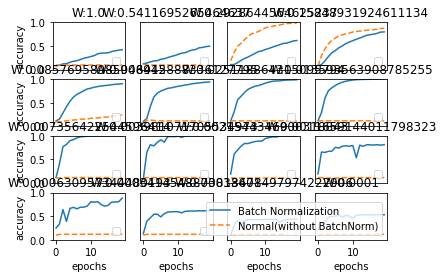

In [8]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

## 6.4.1 오버피팅
### 일부러 오버피팅을 일으킨 후 가중치 감소(weight_decay)의 효과를 관찰합니다.

epoch:0, train acc:0.08333333333333333, test acc:0.0902
epoch:1, train acc:0.08666666666666667, test acc:0.0923
epoch:2, train acc:0.13333333333333333, test acc:0.1072
epoch:3, train acc:0.16, test acc:0.1293
epoch:4, train acc:0.18333333333333332, test acc:0.1497
epoch:5, train acc:0.19666666666666666, test acc:0.1651
epoch:6, train acc:0.21666666666666667, test acc:0.1863
epoch:7, train acc:0.25, test acc:0.1989
epoch:8, train acc:0.27666666666666667, test acc:0.2122
epoch:9, train acc:0.30333333333333334, test acc:0.2299
epoch:10, train acc:0.3333333333333333, test acc:0.2431
epoch:11, train acc:0.35, test acc:0.2562
epoch:12, train acc:0.37, test acc:0.2758
epoch:13, train acc:0.3933333333333333, test acc:0.2889
epoch:14, train acc:0.41, test acc:0.3103
epoch:15, train acc:0.44, test acc:0.3234
epoch:16, train acc:0.44666666666666666, test acc:0.3451
epoch:17, train acc:0.48, test acc:0.3728
epoch:18, train acc:0.4866666666666667, test acc:0.3852
epoch:19, train acc:0.51, test acc:

epoch:160, train acc:0.88, test acc:0.7311
epoch:161, train acc:0.9, test acc:0.7491
epoch:162, train acc:0.9033333333333333, test acc:0.7513
epoch:163, train acc:0.9033333333333333, test acc:0.7444
epoch:164, train acc:0.9166666666666666, test acc:0.7544
epoch:165, train acc:0.9, test acc:0.7475
epoch:166, train acc:0.91, test acc:0.7504
epoch:167, train acc:0.9166666666666666, test acc:0.7529
epoch:168, train acc:0.9033333333333333, test acc:0.7473
epoch:169, train acc:0.8966666666666666, test acc:0.7415
epoch:170, train acc:0.8966666666666666, test acc:0.7431
epoch:171, train acc:0.9, test acc:0.7382
epoch:172, train acc:0.8966666666666666, test acc:0.7319
epoch:173, train acc:0.92, test acc:0.7497
epoch:174, train acc:0.91, test acc:0.7443
epoch:175, train acc:0.9066666666666666, test acc:0.7535
epoch:176, train acc:0.9, test acc:0.7446
epoch:177, train acc:0.9, test acc:0.7441
epoch:178, train acc:0.9133333333333333, test acc:0.7474
epoch:179, train acc:0.91, test acc:0.7461
epoch

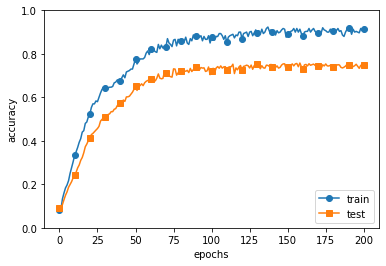

In [4]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 6.4.3 드롭아웃
### 일부러 오버피팅을 일으킨 후 드롭아웃(dropout)의 효과를 관찰합니다.

train loss:2.3063249160188626
=== epoch:1, train acc:0.10333333333333333, test acc:0.0924 ===
train loss:2.30296150866566
train loss:2.315798654485767
train loss:2.3132586498968055
=== epoch:2, train acc:0.10333333333333333, test acc:0.0949 ===
train loss:2.305643998697653
train loss:2.3083530879477383
train loss:2.3026621011745583
=== epoch:3, train acc:0.10333333333333333, test acc:0.0951 ===
train loss:2.314482982278157
train loss:2.3093358349276683
train loss:2.298370543130973
=== epoch:4, train acc:0.10333333333333333, test acc:0.0958 ===
train loss:2.308451931367739
train loss:2.288681551076583
train loss:2.309965733827072
=== epoch:5, train acc:0.10666666666666667, test acc:0.0971 ===
train loss:2.307546017767608
train loss:2.290187768987975
train loss:2.298752849869025
=== epoch:6, train acc:0.10666666666666667, test acc:0.0995 ===
train loss:2.3027569932332677
train loss:2.2831231670217846
train loss:2.300134946902069
=== epoch:7, train acc:0.10666666666666667, test acc:0.0994

=== epoch:57, train acc:0.22333333333333333, test acc:0.1877 ===
train loss:2.2328550394682405
train loss:2.2303168417110526
train loss:2.256979918108712
=== epoch:58, train acc:0.23, test acc:0.1919 ===
train loss:2.259543609036488
train loss:2.233807468747679
train loss:2.230020935933422
=== epoch:59, train acc:0.24, test acc:0.1954 ===
train loss:2.216126826542183
train loss:2.2410276536016767
train loss:2.2449677315230097
=== epoch:60, train acc:0.24, test acc:0.1949 ===
train loss:2.2321611896720257
train loss:2.224130314738559
train loss:2.2087181566841796
=== epoch:61, train acc:0.23333333333333334, test acc:0.1919 ===
train loss:2.2265882026540136
train loss:2.2426562323267007
train loss:2.2376482629163563
=== epoch:62, train acc:0.24, test acc:0.1997 ===
train loss:2.2122013595196197
train loss:2.2290093034018557
train loss:2.242503894719571
=== epoch:63, train acc:0.24333333333333335, test acc:0.2025 ===
train loss:2.214771253810819
train loss:2.2196965893407516
train loss:2.

=== epoch:114, train acc:0.37333333333333335, test acc:0.2778 ===
train loss:2.115655280777362
train loss:2.131378330592527
train loss:2.143655973302837
=== epoch:115, train acc:0.36666666666666664, test acc:0.2844 ===
train loss:2.1495871952091132
train loss:2.078925039241537
train loss:2.1715106509161783
=== epoch:116, train acc:0.38333333333333336, test acc:0.288 ===
train loss:2.1562037241197682
train loss:2.0967222547509845
train loss:2.164611153166472
=== epoch:117, train acc:0.39, test acc:0.2906 ===
train loss:2.054629860778619
train loss:2.103160178013569
train loss:2.0475353646570182
=== epoch:118, train acc:0.38, test acc:0.2897 ===
train loss:2.0453936850608128
train loss:2.0705714371880926
train loss:2.1298680203401332
=== epoch:119, train acc:0.38666666666666666, test acc:0.2932 ===
train loss:2.0081824269731623
train loss:2.0379037630359
train loss:2.1010389170961328
=== epoch:120, train acc:0.37666666666666665, test acc:0.293 ===
train loss:2.051513749643842
train loss:

=== epoch:171, train acc:0.42, test acc:0.3424 ===
train loss:1.91096624327745
train loss:1.8934584509944954
train loss:1.926598725188489
=== epoch:172, train acc:0.41333333333333333, test acc:0.3418 ===
train loss:1.8139804668205761
train loss:1.910735735447887
train loss:1.8591254571108313
=== epoch:173, train acc:0.41333333333333333, test acc:0.3415 ===
train loss:1.8878469100387514
train loss:1.9609145187546533
train loss:1.8706563850019498
=== epoch:174, train acc:0.41333333333333333, test acc:0.3434 ===
train loss:1.8131092977500967
train loss:1.8680085861742974
train loss:1.9834488816569629
=== epoch:175, train acc:0.4166666666666667, test acc:0.3446 ===
train loss:1.813062923814349
train loss:2.011920708113968
train loss:1.8517814554064271
=== epoch:176, train acc:0.42, test acc:0.3476 ===
train loss:1.985822880921829
train loss:1.9289100141897135
train loss:1.8489327476256
=== epoch:177, train acc:0.42333333333333334, test acc:0.352 ===
train loss:1.810086676790528
train loss:

=== epoch:228, train acc:0.49, test acc:0.4175 ===
train loss:1.7021285567472353
train loss:1.7112008894545603
train loss:1.658793566479139
=== epoch:229, train acc:0.49333333333333335, test acc:0.419 ===
train loss:1.6727384111258947
train loss:1.8250290538676435
train loss:1.7035333242613122
=== epoch:230, train acc:0.49666666666666665, test acc:0.4204 ===
train loss:1.659611045913417
train loss:1.7692544247412518
train loss:1.7714940195707498
=== epoch:231, train acc:0.5, test acc:0.4218 ===
train loss:1.5824203343597782
train loss:1.7991076154768222
train loss:1.7406111697827036
=== epoch:232, train acc:0.5033333333333333, test acc:0.4237 ===
train loss:1.6978229537512626
train loss:1.6909548828830083
train loss:1.7807438356141716
=== epoch:233, train acc:0.5066666666666667, test acc:0.4297 ===
train loss:1.711197906451718
train loss:1.7054826809339594
train loss:1.83908035085679
=== epoch:234, train acc:0.5133333333333333, test acc:0.4321 ===
train loss:1.6823578021749117
train lo

=== epoch:285, train acc:0.5966666666666667, test acc:0.5022 ===
train loss:1.5126198474617951
train loss:1.569288236855017
train loss:1.567988724492036
=== epoch:286, train acc:0.5966666666666667, test acc:0.5035 ===
train loss:1.4931779542253554
train loss:1.5602640972467876
train loss:1.649790241839532
=== epoch:287, train acc:0.5933333333333334, test acc:0.5037 ===
train loss:1.5269822950445613
train loss:1.5577129418329918
train loss:1.491060749930697
=== epoch:288, train acc:0.6066666666666667, test acc:0.5092 ===
train loss:1.5028345472353357
train loss:1.57783121451487
train loss:1.3558634401361909
=== epoch:289, train acc:0.6066666666666667, test acc:0.509 ===
train loss:1.4649550090861942
train loss:1.4603372902601088
train loss:1.487427658230092
=== epoch:290, train acc:0.6066666666666667, test acc:0.5099 ===
train loss:1.5394172238997796
train loss:1.5613674399700619
train loss:1.4878346354262042
=== epoch:291, train acc:0.6066666666666667, test acc:0.5105 ===
train loss:1.

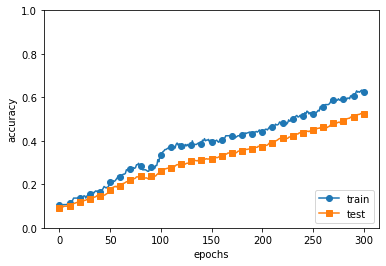

In [5]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


## 6.5.3 하이퍼파라미터 최적화 구현하기
### 무작위로 추출한 값부터 시작하여 두 하이퍼파라미터(가중치 감소 계수, 학습률)를 최적화해봅니다.

val acc:0.13 | lr:0.0003747241765980719, weight decay:1.236893680393832e-07
val acc:0.06 | lr:7.999589711479662e-05, weight decay:9.259602608415874e-06
val acc:0.19 | lr:0.0007338981562440239, weight decay:7.228883190357455e-05
val acc:0.13 | lr:0.00010666330618081424, weight decay:3.691558181524676e-05
val acc:0.05 | lr:1.4160673233381771e-05, weight decay:2.2422205840640943e-07
val acc:0.2 | lr:0.0010481958533630946, weight decay:1.5016629173302157e-05
val acc:0.17 | lr:0.0007327050351543193, weight decay:4.251313617642148e-07
val acc:0.2 | lr:0.0009700286827523554, weight decay:1.5785185891146732e-07
val acc:0.14 | lr:7.791450130053292e-05, weight decay:7.472920262251777e-07
val acc:0.13 | lr:0.00028048505480201186, weight decay:9.704587246652714e-07
val acc:0.14 | lr:7.502887004716594e-06, weight decay:3.104807735766555e-05
val acc:0.08 | lr:0.0003106359658787749, weight decay:2.569021284349971e-05
val acc:0.06 | lr:0.0001109984526614281, weight decay:3.39383518925532e-08
val acc:0

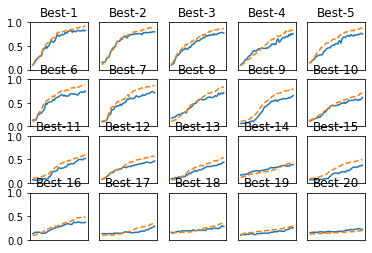

In [2]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()
